In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load traffic data
data = pd.read_csv("data.csv", index_col=0)
agg_mat_df = pd.read_csv("agg_mat.csv", index_col=0)

maximum = np.max(data.values)
data_scaled = (data / maximum).values

seed = 0 

def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # if using nvidia gpu
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

set_seeds(seed)

In [3]:
n_series = data.shape[1] 
n_total = data.shape[0]
n_train = 350
context_window = 5
n_val = 70

data.shape

(514, 57)

In [4]:
def calculate_wmape(actual_values, forecasted_values):
    # compute wMAPE metric
    n = len(actual_values)
    num = np.sum(np.abs(actual_values - forecasted_values))
    den = np.sum(np.abs(actual_values))
    wmape = num/den
    return wmape

def calculate_RMSE(actual_values, forecasted_values): 
    # compute RMSE metric
    squared_errors = (actual_values - forecasted_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(-100.0, 0, '−100'),
  Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600')])

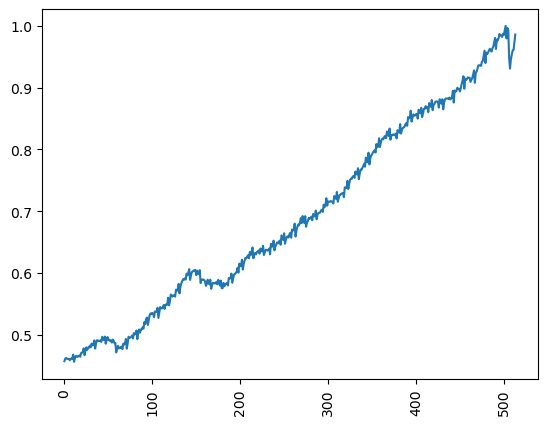

In [5]:
plt.plot(data_scaled[:,0])
plt.xticks(rotation=90)

In [6]:
def make_data(dataset, range_, context_window): 
    # produces X_data and y_data tensors given the dataset 
    X_data = []
    y_data = []
    for i in range_:
        X = dataset[i:i+context_window,:].T.flatten()
        X_data.append(X)

        y = dataset[i+context_window:i+context_window+1,:].T.flatten()
        y_data.append(y)

    return torch.tensor(X_data, dtype=float), torch.tensor(y_data, dtype=float)

In [7]:
class Dataset_Labour(Dataset):
    def __init__(self, root_path, flag='train', data_path='data.csv', context_window=5, n_train=n_train, n_val=n_val, seq_len=n_train-context_window):
        
        # init
        self.root_path = root_path
        self.data_path = data_path
        self.context_window=context_window
        self.n_train = n_train
        self.n_val = n_val
        self.seq_len = seq_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path), index_col=0)
        maximum = np.max(df_raw.values)
        data = (df_raw / maximum).values
        
        X_data = []
        y_data = []

        if self.set_type == 0: 
            data_range = range(self.n_train)
        elif self.set_type == 1: 
            data_range = range(self.n_train, self.n_train + self.n_val)
        else: 
            data_range = range(self.n_train + self.n_val, self.data.shape[0] - self.context_window)

        for i in data_range:
            X = data[i:i+self.context_window,:].T.flatten()
            X_data.append(X)

            y = data[i+self.context_window:i+self.context_window+1,:].T.flatten()
            y_data.append(y)

        self.X = torch.tensor(np.array(X_data))
        self.y = torch.tensor(np.array(y_data))

    def __getitem__(self, index):
        X = self.X[index:index + self.seq_len, :]
        y = self.y[index:index + self.seq_len]
        
        return X, y

    def __len__(self):
        return len(self.X) - context_window - self.seq_len + 1

In [8]:
train_dataset = Dataset_Labour('/home/gridsan/mhensgen/labour', seq_len=50)

In [9]:
train_dataset.X.dtype

torch.float64

In [10]:
X_train, y_train = make_data(data_scaled, range(n_train), context_window)
X_val, y_val = make_data(data_scaled, range(n_train, n_train+n_val), context_window)
X_test, y_test = make_data(data_scaled, range(n_train + n_val,n_total - context_window), context_window)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([350, 285])
torch.Size([70, 285])
torch.Size([89, 285])


/state/partition1/slurm_tmp/25964723.0.0/ipykernel_2515456/3169270821.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(X_data, dtype=float), torch.tensor(y_data, dtype=float)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

aggregation_mat = torch.tensor(np.append(np.zeros((agg_mat_df.shape[0], agg_mat_df.shape[0] - agg_mat_df.shape[1])), agg_mat_df, axis=1), dtype=float).to(device)
S = agg_mat_df.values

def coherency_loss(network): 
    # computes coherency on last layer of the network 
    repeated_bias = network.last_layer.bias.repeat(network.last_layer.weight.shape[0], 1)
    return torch.norm(aggregation_mat @ network.last_layer.weight - network.last_layer.weight) + torch.norm(
        aggregation_mat @ repeated_bias - repeated_bias) 

def coherency_metric(predictions):
    print(predictions.shape)
    # computes the actual coherency of predictions 
    return torch.norm(predictions.T - aggregation_mat @ predictions.T) / predictions.shape[1]

def create_M(S): 
    # creates the projection matrix M given the aggregation matrix S
    m, m_K = S.shape
    m_agg = m-m_K

    # The top `m_agg` rows of the matrix `S` give the aggregation constraint matrix.
    S_agg = S[:m_agg, :]
    print(S_agg.shape)
    A = np.hstack((np.eye(m_agg), -S_agg))

    M = np.eye(m) - A.T @ np.linalg.pinv(A @ A.T) @ A  

    return torch.from_numpy(M).float(), torch.from_numpy(A).float()


M, A = create_M(S)

def project_samples(y): 
    # project y using S (aggregation matrix )
    # y should have shape n_samples x n_series
    # y = y
    # n_samples, n_series = y.shape
    # eye = torch.eye(n_series).float()
    # eye = eye.reshape((1, n_series, n_series))
    # n_samples_eye = eye.repeat(n_samples, 1, 1)
    # Q = 2*n_samples_eye
    # G = -n_samples_eye
    # p = -2*y
    # b = torch.zeros((n_samples, A.shape[0])).float()
    # h = torch.zeros((n_samples, n_series)).float()
    # A_rep = A.repeat(n_samples, 1, 1)
    # y_proj = QPFunction(verbose=False)(Q, p, G, h, A_rep, b)

    return torch.matmul(y, M.double().to(device))


cuda
(25, 32)


In [12]:
aggregation_mat

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

In [13]:
class LstmNet(nn.Module):
    def __init__(self, n_series, context, should_project=False):
        """
        n_series = number of time series we have
        context = size of context window (how many samples back we are using to predict)
        should_project: boolean determining if we use a projection before output for coherency
        """
        super().__init__()
        print(n_series) 
        set_seeds(seed)
        hidden_size = int(n_series * context / 2)
        self.lstm =  nn.LSTM(input_size=n_series * context, hidden_size=hidden_size, dropout=0.2, num_layers=2, dtype=float)
        self.last_layer = nn.Linear(hidden_size, n_series, dtype=float)
        self.should_project = should_project
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size, dtype=float)
    

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x)
        x_3d = len(x.shape) >= 3
        if x_3d: 
            x = x.transpose(1,2)
        x = self.batch_norm(x)
        if x_3d: 
            x = x.transpose(1,2)
        out = self.last_layer(x)

        if self.should_project: 
            out = project_samples(out)
            
        return out

In [14]:
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR

def train_net(n_epochs, batch_size=10, coherent=False, alpha=0, should_project=False, alpha_scaling=0, least_squares=False, scaling_increase_factor=0,
               verbose=False, should_schedule=False, plot_loss=False, lr=0.001, max_grad_norm=10, update_alpha_epoch=100): 
    """
    trains an LSTMNet on the traffic dataset based on the given parameters
    coherent: if true, uses coherent loss 
    alpha: the term we multiply the 'coherency_loss' by in calculating overall loss 
    should_project: if true, uses projection method 
    alpha_scaling: if a number, we will scale alpha by alpha_scaling * l1/l2. 
    essentially, we are setting l1 = l2*alpha, so the coherency will be weighted by 'alpha_scaling' in the loss
    """
    # sets the number of epochs we train before updating alpha 

    network = LstmNet(n_series, context_window, should_project=should_project)
    network = network.to(device)
    
    train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=False)

    print('--- alpha {alpha} ---- lr  {lr}----'.format(alpha=alpha, lr=lr))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    if should_schedule: 
        if scaling_increase_factor > 0: 
            scheduler = MultiStepLR(optimizer, milestones=[i for i in range(update_alpha_epoch + 1, n_epochs, update_alpha_epoch)], gamma=1-scaling_increase_factor)
        else: 
            scheduler = MultiStepLR(optimizer, milestones=[750, 1500, 2250], gamma=0.99)

    losses = []
    l1s = [] 
    l2s = []
    validation_loss =[] 
    
    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times

        inputs, labels = next(iter(train_dataloader))
        
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # print(inputs[0, :20, 0])
        # print(labels[0, :20, 0]) 
        # print(X_train[:20, 0]) 
        # print(y_train[:20, 0]) 

        optimizer.zero_grad()

        outputs = network(inputs)

        # add coherency network loss
        if coherent: 
            l1 = criterion(outputs, labels) 
            l2 = coherency_loss(network)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())
        
        elif least_squares: 
            l1 = criterion(outputs, labels) 
            l2 = 0
            # TODO: speed this up with batching 
            for i in range(outputs.shape[0]): 
                l2 = l2 + torch.norm(outputs[i, :, :].T - aggregation_mat @ outputs[i, :, :].T)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())

        # normal loss
        else: 
            loss = criterion(outputs, labels)
            validation_loss.append(criterion(network(X_val.to(device)), y_val.to(device)).item())

        loss.backward()

        nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)

        optimizer.step()

        losses.append(loss.item())

        if epoch % update_alpha_epoch == 0 and epoch > 0:   
            if verbose:  
                print("Epoch:", epoch, " Loss: ", np.mean(losses))
                print(np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch])))
                print(np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch])))
            # plt.figure()
            # plt.plot(range(len(losses[epoch-100:epoch])), losses[epoch-100:epoch], label='training')
            # plt.plot(range(len(validation_loss[epoch-100:epoch])), validation_loss[epoch-100:epoch], label='validation')
            # plt.legend()
            # plt.show()

            if (coherent or least_squares) and (alpha_scaling or scaling_increase_factor > 0): 
                with torch.no_grad():
                    l1_mean = np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch]))
                    l2_mean =  np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch]))
                    alpha = l1_mean/l2_mean * alpha_scaling
                    alpha_scaling = alpha_scaling + scaling_increase_factor
                    if verbose: 
                        print('scaled: ', l1_mean/l2_mean)
                        print('RMSE mean: ', l1_mean)
                        print('Coherency Loss mean: ', l2_mean)
                        print('alpha: ', alpha)
                        print('alpha scaling: ', alpha_scaling)

        if should_schedule: 
            scheduler.step()

            
    # plotting 
    plot_start = 0
    start_2 = 101
    if plot_loss: 
        plt.plot(range(len(losses[plot_start:])), losses[plot_start:], label='Train')
        plt.plot(range(len(losses[plot_start:])), validation_loss[plot_start:], label='val')
        plt.title('RMSE starting at epoch {plot_start}'.format(plot_start=plot_start))
        plt.legend()
        plt.show()
        if coherent: 
            plt.plot(range(len(l2s[plot_start:])), l2s[plot_start:], label='Coherency Loss')
            plt.title('Coherency Loss loss starting at epoch {plot_start}'.format(plot_start=plot_start))
            plt.legend() 
            plt.show()
        if start_2: 
            plt.plot(range(len(losses[start_2:])-4), [(losses[i] + losses[i + 1] + losses[i + 2] + losses[i + 3] + losses[i + 4])/5 for i in range(start_2, len(losses)-4)], label='Train')
            plt.plot(range(len(losses[start_2:])-6), [(validation_loss[i] + validation_loss[i + 1] + validation_loss[i + 2] + validation_loss[i + 3] + validation_loss[i + 4] + validation_loss[i + 5] + validation_loss[i + 6])/7 for i in range(start_2, len(losses)-6)], label='val')
            plt.title('RMSE starting at epoch {plot_start}'.format(plot_start=start_2))
            plt.legend()
            plt.show()
            if coherent: 
                plt.plot(range(len(l2s[start_2:])), l2s[start_2:], label='Coherency Loss')
                plt.title('Coherency loss starting at epoch {plot_start}'.format(plot_start=start_2))
                plt.legend() 
                plt.show()
    
    return network, losses


In [15]:
def visualize(ts, networks, labels, starting_zone = 0): 
    """
    Visualizes the networks' predictions on a specific time series 
    ts: time series to visualize
    labels: labels of the networks for plotting
    defining each zone as 50 points just so the graphs are easier to see 
    networks and labels should have same length
    """
    with torch.no_grad(): 
        truth = y_test.numpy()[:,ts]
        start_time = starting_zone*50
        end_time = start_time + 50
        plt.plot(truth[start_time:end_time], label = 'truth')

        for i in range(len(networks)): 
            predict_net = networks[i](X_test).numpy()[:,ts]

            plt.plot(predict_net[start_time:end_time], label = labels[i])
        plt.legend()

In [16]:
def calculate_mean_RMSE(network): 
    network.lstm.eval()  
    return calculate_RMSE(y_test.numpy(), network(X_test.to(device)).cpu().detach().numpy())


def get_metrics(networks, verbose=False): 
    rmses = []
    network_coherencies = [] 
    ll_losses = [] 
    #print(networks)
    for network in networks: 
        network.lstm.eval() 
        rmse = calculate_mean_RMSE(network)
        network_coherency = coherency_metric(network(X_test.to(device))).item() 
        ll_loss = coherency_loss(network).item()
        if verbose: 
            print("RMSE: ", rmse)
            print("Network coherency: ", network_coherency)
            print("Last Layer Coherency Loss: ", ll_loss)
        rmses.append(rmse)
        network_coherencies.append(network_coherency)
        ll_losses.append(ll_loss)
    return rmses, network_coherencies, ll_losses

In [17]:
def save_model(model, name): 
    torch.save(model.state_dict(), name + '.pth')

In [18]:
def load_model(path, should_project): 
    model = LstmNet(n_series, context_window, should_project=should_project)
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model 

# Baselines

In [19]:
trained_baselines = True
trained_projection = True

In [26]:
n_trials = 5

baseline_metrics = np.zeros((4, n_trials))
baseline_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_baselines: 
        baseline_network = load_model('baseline_batching_{i}.pth'.format(i=i), False)
    else:
        baseline_network, loss = train_net(500, batch_size=100, plot_loss=True, lr=0.00025)
        save_model(baseline_network, 'baseline_batching_{i}'.format(i=i))
        
    rmse_baseline, network_coherency_baseline, network_loss_baseline = get_metrics([baseline_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), baseline_network(X_val.to(device)).detach().cpu().numpy())
    baseline_metrics[:, i] = [rmse_baseline[0], network_coherency_baseline[0], network_loss_baseline[0], validation_loss]
    baseline_networks.append(baseline_network) 

57
torch.Size([89, 57])
RMSE:  0.07259359006184414
Network coherency:  0.05108247221173131
Last Layer Coherency Loss:  15.280304214755283
57
torch.Size([89, 57])
RMSE:  0.07895748792373128
Network coherency:  0.06462523511431072
Last Layer Coherency Loss:  16.738201899331056
57
torch.Size([89, 57])
RMSE:  0.07791100944098138
Network coherency:  0.08232283283783005
Last Layer Coherency Loss:  15.037829694792137
57
torch.Size([89, 57])
RMSE:  0.0724705562066187
Network coherency:  0.04857781133763455
Last Layer Coherency Loss:  15.16784194344263
57
torch.Size([89, 57])
RMSE:  0.07450334389880572
Network coherency:  0.06117929874193026
Last Layer Coherency Loss:  15.0258488631546


57
--- alpha 0 ---- lr  0.00025----


100%|██████████| 1000/1000 [00:40<00:00, 24.99it/s]


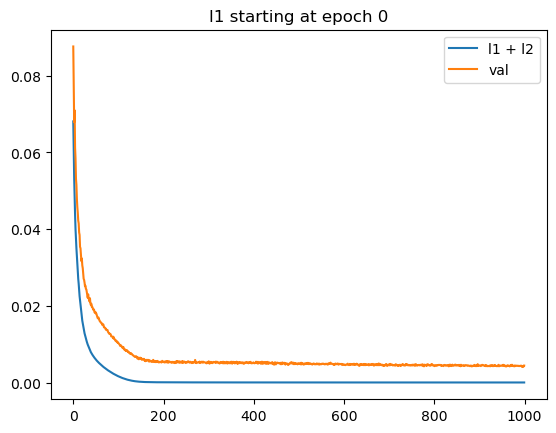

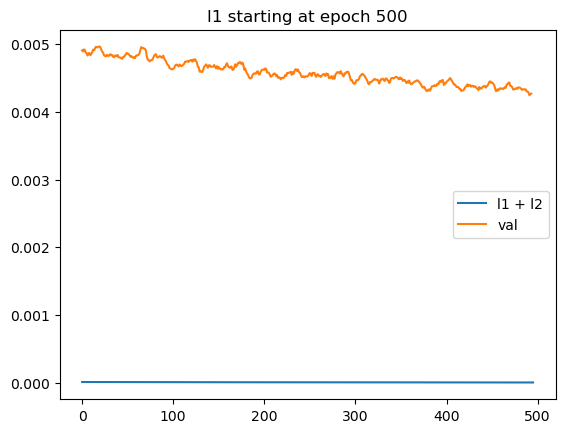

RMSE:  0.07304950837731904
Network coherency:  1.2987864832105462e-08
Last Layer Coherency Loss:  18.981235468047117
57
--- alpha 0 ---- lr  0.00025----


100%|██████████| 1000/1000 [00:40<00:00, 24.84it/s]


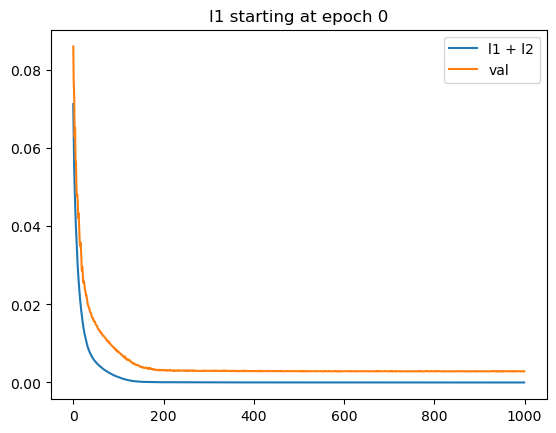

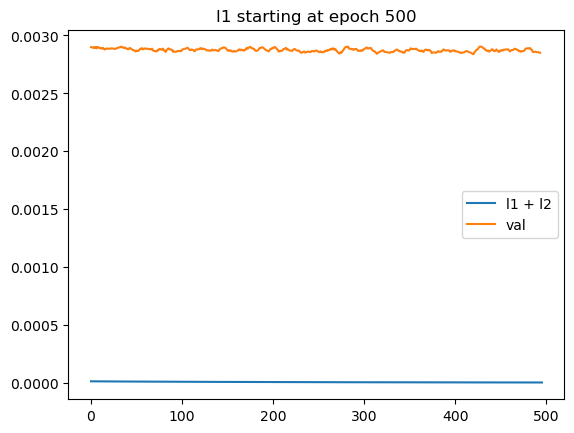

RMSE:  0.06725994560852805
Network coherency:  1.1696230380441106e-08
Last Layer Coherency Loss:  18.91863125547978
57
--- alpha 0 ---- lr  0.00025----


100%|██████████| 1000/1000 [00:40<00:00, 24.86it/s]


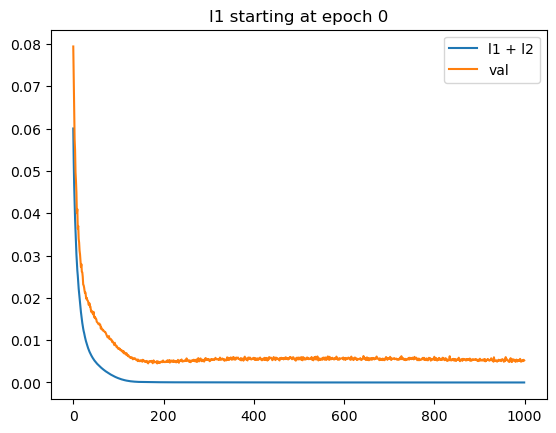

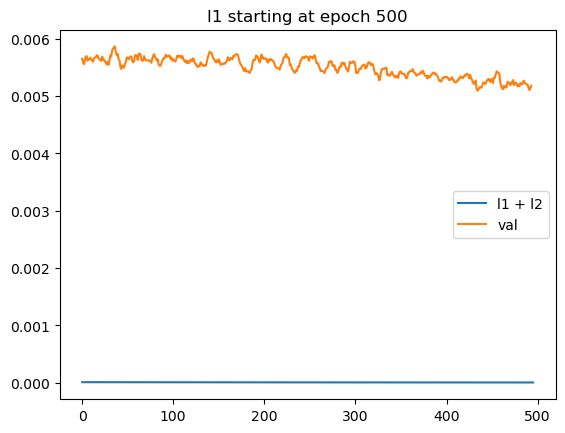

RMSE:  0.07968559706872573
Network coherency:  1.2802649359259166e-08
Last Layer Coherency Loss:  19.288661428457317
57
--- alpha 0 ---- lr  0.00025----


100%|██████████| 1000/1000 [00:39<00:00, 25.15it/s]


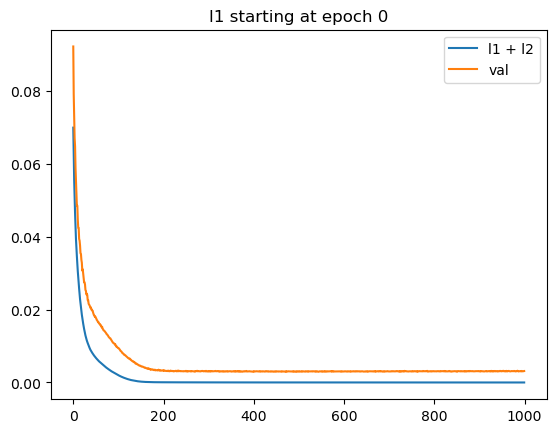

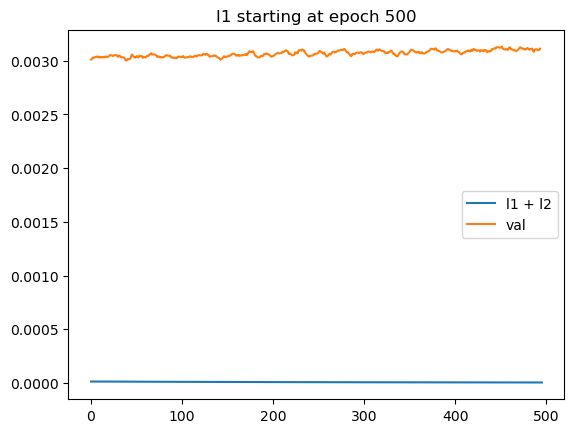

RMSE:  0.06863545913265771
Network coherency:  1.6195611811038203e-08
Last Layer Coherency Loss:  19.270628974705115
57
--- alpha 0 ---- lr  0.00025----


100%|██████████| 1000/1000 [00:40<00:00, 24.88it/s]


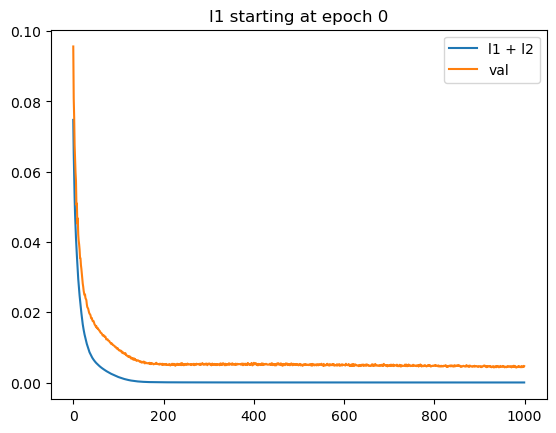

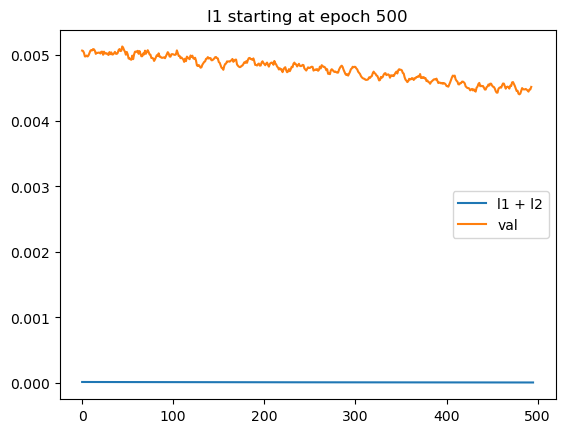

RMSE:  0.07326344248847752
Network coherency:  1.1512890146887692e-08
Last Layer Coherency Loss:  17.118091465655294


In [23]:
projection_metrics = np.zeros((4, n_trials))  
projection_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_projection: 
        projection_network = load_model('projection_batched_{i}.pth'.format(i=i), True)
    else: 
        projection_network, loss = train_net(1000, batch_size=100, plot_loss=True, should_project=True, lr=0.00025)
        save_model(projection_network, 'projection_batched_{i}'.format(i=i))
        
    rmse_projection, network_coherency_projection, network_loss_projection = get_metrics([projection_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), projection_network(X_val.to(device)).detach().cpu().numpy())
    projection_metrics[:, i] = [rmse_projection[0], network_coherency_projection[0], network_loss_projection[0], validation_loss]
    projection_networks.append(rmse_projection) 

In [41]:
print(baseline_metrics.mean(axis=1)) 
print(baseline_metrics.std(axis=1)) 
print(projection_metrics.mean(axis=1))
print(projection_metrics.std(axis=1))

[ 0.07768671  0.07184513 15.46250347  0.06169599]
[0.00416362 0.01875107 0.64800881 0.00399871]
[7.23787905e-02 1.30390493e-08 1.87154497e+01 5.69165137e-02]
[4.35515778e-03 1.68254070e-09 8.12437550e-01 3.24060679e-03]


# Parameter Experiments 

In [20]:
alpha_experiments = [0.01, 0.1, 1, 10, 100, 1000]
alpha_scale_experiments = [0.05, .25, 1, 5, 20, 50]
alpha_scale_increment_experiments = [0.1, 0.5, 1, 5, 10, 50]

57
--- alpha 100 ---- lr  0.004767397875016922----


100%|██████████| 500/500 [00:26<00:00, 18.86it/s]


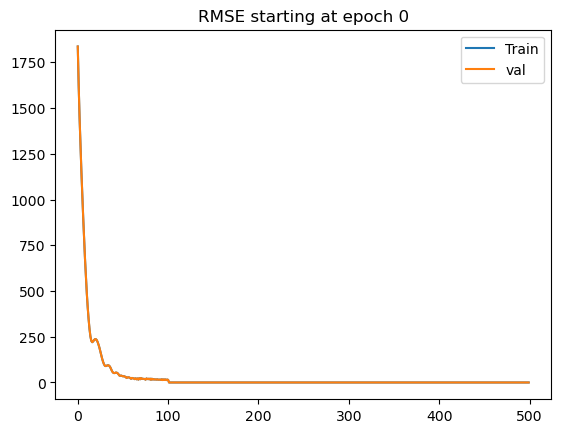

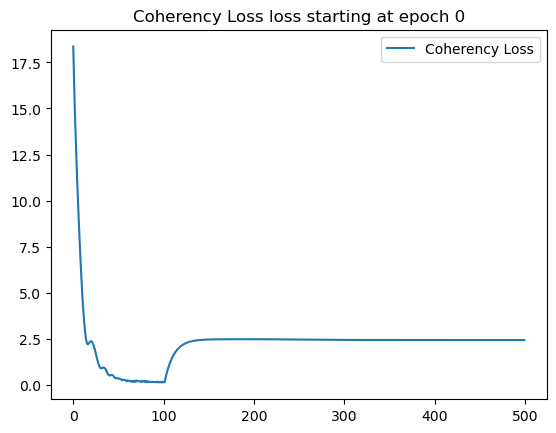

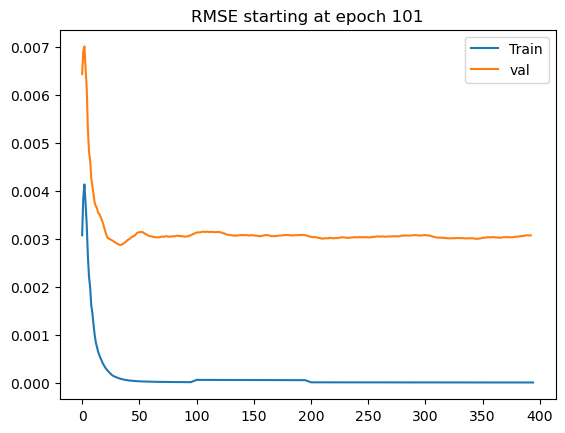

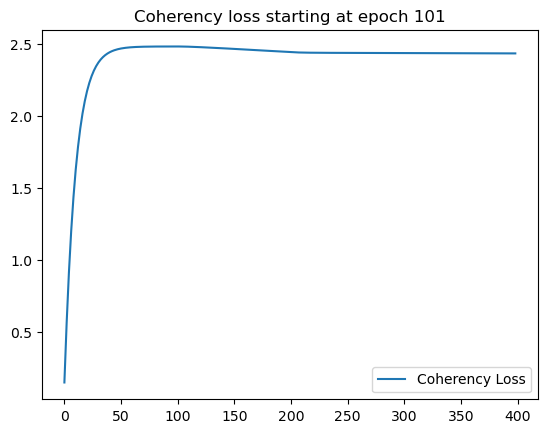

torch.Size([89, 57])
RMSE:  0.06964926646573728
Network coherency:  0.016715541785449064
Last Layer Coherency Loss:  2.4317793189276515
57
--- alpha 100 ---- lr  0.00408782762630579----


 53%|█████▎    | 263/500 [00:10<00:09, 26.22it/s]


KeyboardInterrupt: 

In [23]:
const_alpha = 100
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = False

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_alpha_100_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_alpha_100_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

In [21]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test


NameError: name 'metrics_increment' is not defined

In [22]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

57
torch.Size([89, 57])
RMSE:  0.06559575835218069
Network coherency:  0.0028312871131418393
Last Layer Coherency Loss:  12.637806843770827
57
torch.Size([89, 57])
RMSE:  0.065611096970212
Network coherency:  0.0025230159286577713
Last Layer Coherency Loss:  8.979775632675011
57
torch.Size([89, 57])
RMSE:  0.06570145405970086
Network coherency:  0.006778047552161824
Last Layer Coherency Loss:  7.458065428399426
57
torch.Size([89, 57])
RMSE:  0.066046740448735
Network coherency:  0.01341006002736809
Last Layer Coherency Loss:  5.54114501873659
57
torch.Size([89, 57])
RMSE:  0.0665408167305132
Network coherency:  0.016660423702512972
Last Layer Coherency Loss:  4.2582145179842055
57
torch.Size([89, 57])
RMSE:  0.06719323555893468
Network coherency:  0.009012497347495095
Last Layer Coherency Loss:  1.669699274031333
57
torch.Size([89, 57])
RMSE:  0.06561859553900001
Network coherency:  0.00543357450831374
Last Layer Coherency Loss:  12.305030702674774
57
torch.Size([89, 57])
RMSE:  0.0655

# Least Squares

In [30]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('least_squares_scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=100, least_squares=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'least_squares_scaling_increment_batched_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

57
torch.Size([89, 57])
RMSE:  0.06574744394494725
Network coherency:  0.008442150465008163
Last Layer Coherency Loss:  11.160302023655118
57
torch.Size([89, 57])
RMSE:  0.06579357663455687
Network coherency:  0.016535199803404507
Last Layer Coherency Loss:  11.234931470699932
57
torch.Size([89, 57])
RMSE:  0.06576016954042255
Network coherency:  0.016807991320003445
Last Layer Coherency Loss:  11.364383556728448
57
torch.Size([89, 57])
RMSE:  0.06658033664437091
Network coherency:  0.012804985597473409
Last Layer Coherency Loss:  11.245036250148825
57
torch.Size([89, 57])
RMSE:  0.0692238801626053
Network coherency:  0.009388678939872195
Last Layer Coherency Loss:  10.772971532899817
57
torch.Size([89, 57])
RMSE:  0.11395237631929006
Network coherency:  0.003053185060680933
Last Layer Coherency Loss:  10.822483180747938
57
torch.Size([89, 57])
RMSE:  0.06570581914295635
Network coherency:  0.006012703257202109
Last Layer Coherency Loss:  11.162588133581473
57
torch.Size([89, 57])
RMSE

In [31]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

test
[0.06569923 0.06574909 0.06576066 0.06639786 0.07025176 0.11492481]
[2.93915206e-05 2.63508407e-05 7.04647884e-05 1.12220256e-04
 2.87664808e-03 3.09582604e-03]
validation
[0.05181991 0.05203464 0.05209661 0.0526881  0.05641572 0.10125309]
[5.06409150e-05 6.21331047e-05 6.52567798e-05 1.20257538e-04
 2.84326830e-03 3.10120444e-03]
coherency
[0.0077701  0.01316065 0.0148147  0.01573168 0.00954544 0.00311528]


In [25]:
metrics_increment.shape

(4, 5, 6)

In [35]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
proj_inc_trained = True

metrics_project_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))
networks_project_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if proj_inc_trained: 
            network = load_model('projection_inc_batched_{inc}_trial={i}.pth.pth'.format(inc=scaling_increase_factor, i=i), True)
        else: 
            network, loss = train_net(500, batch_size=100, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=True,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'projection_inc_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_project_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_project_increment[i].append(network)
        
        scaling_idx += 1

print('test')
print(metrics_project_increment.mean(axis=1)[0, :])
print(metrics_project_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_project_increment.mean(axis=1)[3, :])
print(metrics_project_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_project_increment.mean(axis=1)[1, :])

57
RMSE:  0.06563357501878118
Network coherency:  9.790762567955046e-09
Last Layer Coherency Loss:  18.751278704615217
57
RMSE:  0.06567113557321674
Network coherency:  9.215090201576976e-09
Last Layer Coherency Loss:  14.790342799187698
57
RMSE:  0.06571867859413213
Network coherency:  1.0826843355424532e-08
Last Layer Coherency Loss:  12.707301143891701
57
RMSE:  0.06585372528975633
Network coherency:  1.0986892182562094e-08
Last Layer Coherency Loss:  6.5016396344211795
57
RMSE:  0.06588473252550796
Network coherency:  1.2450299378162935e-08
Last Layer Coherency Loss:  4.640016617990569
57
RMSE:  0.07091181458023711
Network coherency:  8.499132969866009e-09
Last Layer Coherency Loss:  3.1270538125315928
57
RMSE:  0.06567393670793176
Network coherency:  1.3409843376544735e-08
Last Layer Coherency Loss:  18.413598003335046
57
RMSE:  0.0656890231334959
Network coherency:  1.4752023739751779e-08
Last Layer Coherency Loss:  14.518128051758453
57
RMSE:  0.0656153672293622
Network coherenc

In [37]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_experiments)))
networks_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for alpha in alpha_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('alpha_{alpha}_trial={i}.pth'.format(alpha=alpha, i=i), False)
        else: 
            network, loss = train_net(500, batch_size=100, coherent=True, alpha=alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=5, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'alpha_{alpha}_trial={i}'.format(alpha=alpha, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        networks_increment[i].append(network) 
        
        scaling_idx += 1

print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

57
RMSE:  0.06742158053320144
Network coherency:  0.00027916447211662855
Last Layer Coherency Loss:  0.03786913301459464
57
RMSE:  0.06692181151699719
Network coherency:  5.382831707455446e-05
Last Layer Coherency Loss:  0.0024153423942747565
57
RMSE:  0.067334441903318
Network coherency:  0.00036621165822587113
Last Layer Coherency Loss:  0.07462724803932497
57
RMSE:  0.06606686668954735
Network coherency:  0.0002062523315100066
Last Layer Coherency Loss:  0.06340191206065486
57
RMSE:  0.06589637930888785
Network coherency:  0.00026055369801916787
Last Layer Coherency Loss:  0.021698331682454136
57
RMSE:  0.0660419205930049
Network coherency:  0.0002572122696446383
Last Layer Coherency Loss:  0.025497555540147845
57
RMSE:  0.06759275285082121
Network coherency:  0.00011955201098782981
Last Layer Coherency Loss:  0.029565548147545202
57
RMSE:  0.06715521789442447
Network coherency:  4.9120968506925094e-05
Last Layer Coherency Loss:  0.001241728008810354
57
RMSE:  0.06653963001797496
Ne

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_scale_increment = [train_net(10000, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, 
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1 + scaling_increase_factor/4)), 
                                      plot_loss=True) for scaling_increase_factor in [10]]

get_metrics(networks_scale_increment, verbose=True)

In [ ]:
mean_rmses_if = np.mean(metrics_increment[0], axis=0)
std_rmses_if = np.std(metrics_increment[0], axis=0)

print(mean_rmses_if)
print(std_rmses_if) 

mean_network_coherencies_if = np.mean(metrics_increment[1], axis=0)
std_network_coherencies_if = np.std(metrics_increment[1], axis=0)

mean_ll_losses_if = np.mean(metrics_increment[2], axis=0)
std_ll_losses_if = 2*np.std(metrics_increment[2], axis=0)

print(mean_network_coherencies_if)
print(std_network_coherencies_if) 

# Calculate mean and std for baseline and projection metrics
mean_metrics_baseline = np.mean(baseline_metrics, axis=1)
std_metrics_baseline = 2*np.std(baseline_metrics, axis=1)

mean_metrics_projection = np.mean(projection_metrics, axis=1)
std_metrics_projection = 2*np.std(projection_metrics, axis=1)

print(mean_metrics_baseline)
print(std_metrics_baseline)
print(mean_metrics_projection)
print(std_metrics_projection) 

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

# RMSE plot with error bars
ax1.set_title('RMSE vs alpha scaling increment')
ax1.errorbar(alpha_scale_increment_experiments, mean_rmses_if, yerr=std_rmses_if, fmt='o', label='Incremental')
ax1.axhline(mean_metrics_baseline[0], color='red', label='Baseline', linestyle='--')
ax1.axhline(mean_metrics_projection[0], color='blue', label='Projection', linestyle='--')
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_baseline[0]-std_metrics_baseline[0], mean_metrics_baseline[0]+std_metrics_baseline[0], color='red', alpha=0.2)
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_projection[0]-std_metrics_projection[0], mean_metrics_projection[0]+std_metrics_projection[0], color='blue', alpha=0.2)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('Alpha')
ax1.legend()

# Network coherency plot with error bars
ax2.set_title('Coherency on data vs alpha, incremental')
ax2.errorbar(alpha_scale_increment_experiments, mean_network_coherencies_if, yerr=std_network_coherencies_if, fmt='o')
ax2.set_ylabel('Coherency on data')
ax2.set_xlabel('Alpha')

# Last layer coherency plot with error bars
ax3.errorbar(alpha_scale_increment_experiments, mean_ll_losses_if, yerr=std_ll_losses_if, fmt='o')
ax3.set_ylabel('Last layer coherency')
ax3.set_xlabel('Alpha')

plt.tight_layout()
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_project = [train_net(6000, coherent=True, alpha=0, alpha_scaling=0, should_project=True, plot_loss=True,
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1+scaling_increase_factor/4))) for scaling_increase_factor in alpha_scale_increment_experiments]

get_metrics(networks_project, verbose=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))
ax1.set_title('metrics vs alpha scaling increment with projection')
ax1.scatter(alpha_scale_experiments, rmses_if)
ax1.axhline(rmse_baseline, color='red', label='baseline')
ax1.axhline(rmse_projection, color='green', label='projection')
ax1.set_ylabel('rmse')
ax1.set_xlabel('alpha')
ax1.legend()
#ax2.set_title('coherency on data vs alpha, no scaling and no scaling increment')
ax2.scatter(alpha_scale_experiments, network_coherencies_if)
ax2.set_ylabel('coherency on data')
ax2.set_xlabel('alpha')
#ax3.set_title('last layer coherency vs alpha, no scaling and no scaling increment')
ax3.scatter(alpha_scale_experiments, ll_losses_if)
ax3.set_ylabel('last layer coherency')
ax3.set_xlabel('alpha')
plt.show()

In [ ]:
#network, losses = train_net(1000, coherent=False) 
#network_coherent, losses_coherent = train_net(1000, coherent=True, alpha=0)
#network_coherent_high_scaling, losses_coherent_high_scaling = train_net(1000, coherent=True, alpha=0.25, alpha_scaling=1)
network_projection, losses_projection = train_net(5000, should_project=True)
#network_coherent_and_projecting, losses_projection_high_scaling = train_net(1000, coherent=True, alpha=0.5, alpha_scaling=1, should_project=True)

In [ ]:
plt.plot(range(len(losses_projection[100:])), losses_projection[100:], label='projection')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
#plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
#plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
#plt.legend() 

In [ ]:
rmse_projection = calculate_mean_RMSE(network_projection)
rmse_projection

In [ ]:
rmse_projection = 0.0032 

In [ ]:
network_baseline, losses_baseline = train_net(2000, coherent=False)

In [ ]:
rmse_baseline = calculate_mean_RMSE(network_baseline)
rmse_baseline

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Labour Dataset')

# First Set of Data
axs[0, 0].set_title('Alpha Experiments (No Scaling and No Scaling Increment)')
axs[0, 0].scatter(alpha_experiments, rmses)
axs[0, 0].set_ylabel('rmse')
axs[0, 0].set_xlabel('alpha')
axs[0, 0].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 0].axhline(rmse_projection, color='green', label='projection')
axs[0, 0].legend()

axs[1, 0].scatter(alpha_experiments, network_coherencies)
axs[1, 0].set_ylabel('coherency on data')
axs[1, 0].set_xlabel('alpha')
axs[1, 0].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 0].legend()

axs[2, 0].scatter(alpha_experiments, ll_losses)
axs[2, 0].set_ylabel('last layer coherency')
axs[2, 0].set_xlabel('alpha')

# Second Set of Data
axs[0, 1].set_title('Alpha Scaling Experiments (Constant alpha = 0)')
axs[0, 1].scatter(alpha_scale_experiments, rmses_s)
axs[0, 1].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 1].axhline(rmse_projection, color='green', label='projection')
axs[0, 1].set_ylabel('rmse')
axs[0, 1].set_xlabel('alpha scaling')
axs[0, 1].legend()

axs[1, 1].scatter(alpha_scale_experiments, network_coherencies_s)
axs[1, 1].set_ylabel('coherency on data')
axs[1, 1].set_xlabel('alpha scaling')
axs[1, 1].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 1].legend()

axs[2, 1].scatter(alpha_scale_experiments, ll_losses_s)
axs[2, 1].set_ylabel('last layer coherency')
axs[2, 1].set_xlabel('alpha scaling')

# Third Set of Data
axs[0, 2].set_title('Scaling Increment Experiments (Constant alpha = 0, scaling = 0)')
axs[0, 2].scatter(alpha_scale_increment_experiments, rmses_if)
axs[0, 2].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 2].axhline(rmse_projection, color='green', label='projection')
axs[0, 2].set_ylabel('rmse')
axs[0, 2].set_xlabel('alpha increment')
axs[0, 2].legend()

axs[1, 2].scatter(alpha_scale_increment_experiments, network_coherencies_if)
axs[1, 2].set_ylabel('coherency on data')
axs[1, 2].set_xlabel('alpha increment')
axs[1, 2].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 2].legend()

axs[2, 2].scatter(alpha_scale_increment_experiments, ll_losses_if)
axs[2, 2].set_ylabel('last layer coherency')
axs[2, 2].set_xlabel('alpha increment')

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')
axs[2,0].set_xscale('log')
axs[2,1].set_xscale('log')
axs[2,2].set_xscale('log')

plt.tight_layout()
plt.savefig('parameter_experiments_traffic.png')
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_increment_scaled = [train_net(4000, coherent=True, alpha=0, alpha_scaling=0, should_project=True,
                            scaling_increase_factor=scaling_increase_factor + 0.1, lr=0.005/(1 + np.log(1+scaling_increase_factor))) for scaling_increase_factor in alpha_scale_experiments]

get_metrics(networks_increment_scaled, verbose=True)

In [ ]:
# TODO: implement a function that chooses alpha based on the best training data and hopefully show that the selected alpha also performs well on test data

def test_best_alpha(networks):

    train_rmses = [] 
    test_rmses = [] 

    for network, _ in networks: 

        network.lstm.eval() 
        train_rmse = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        test_rmse = calculate_RMSE(y_test.numpy(), network(X_test.to(device)).detach().cpu().numpy())

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    return train_rmses, test_rmses

In [ ]:
train_rmses, test_rmses = test_best_alpha(networks_scale_increment)
#train_rmses_scaled, test_rmses_scaled = test_best_alpha(networks_increment_scaled)
# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(train_rmses, test_rmses)

plt.axhline(rmse_projection, color='green', label='projection')
plt.axhline(rmse_baseline, color='red', label='baseline')

# Annotate each point with its label
for i, label in enumerate(alpha_scale_increment_experiments):
    plt.annotate(label, (train_rmses[i], test_rmses[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize the plot
plt.title('Test RMSE vs. Validation RMSE. Labels are Alpha Scaling Increment Values')
plt.xlabel('Validation RMSE')
plt.ylabel('Test RMSE')

# # Set custom axis limits
# plt.xlim(0.0010, 0.0013)
# plt.ylim(0.004, 0.0055)

# Show the plot
plt.legend() 
plt.savefig('val_traffic.png')
plt.show()

In [ ]:
test_best_alpha(networks)

In [ ]:
# plot losses for learning
#plt.plot(range(len(losses[100:])), losses[100:], label='base')
plt.plot(range(len(losses_projection[100:1000])), losses_projection_high_scaling[100:1000], label='projection')
plt.legend()
plt.show()
plt.figure()
plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
plt.legend() 

In [ ]:
# printing the real coherency of each network we trained
print("baseline network coherency", coherency_metric(network(X_test)).item())
print("coherent network coherency", coherency_metric(network_coherent(X_test)).item())
print("coherent network coherency (high scaling)", coherency_metric(network_coherent_high_scaling(X_test)).item())
#print("projection network coherency", coherency_metric(network_projection(X_test)).item())
#print("both coherency", coherency_metric(network_coherent_and_projecting(X_test)).item())

In [ ]:
n_iters = 20

def calculate_mean_RMSE(network, n_iters=n_iters): 
    errs = np.zeros((n_iters, )) 
    for i in range(n_iters): 
        errs[i] = calculate_RMSE(y_test.numpy(), network(X_test).detach().numpy())
    return np.mean(errs)

print("RMSE Baseline:", calculate_mean_RMSE(network))
print("RMSE Coherent:", calculate_mean_RMSE(network_coherent))
print("RMSE Coherent (high scaling):", calculate_mean_RMSE(network_coherent_high_scaling))
print("RMSE Projection:", calculate_mean_RMSE(network_projection))
print("RMSE Both:", calculate_mean_RMSE(network_coherent_and_projecting))

In [ ]:
print("WMAPE Baseline:", calculate_wmape(y_test.numpy(), network(X_test).detach().numpy()))
print("WMAPE Coherent:", calculate_wmape(y_test.numpy(), network_coherent(X_test).detach().numpy()))
print("WMAPE Coherent (high scaling):", calculate_wmape(y_test.numpy(), network_coherent_high_scaling(X_test).detach().numpy()))
print("WMAPE Projection:", calculate_wmape(y_test.numpy(), network_projection(X_test).detach().numpy()))
print("WMAPE Both:", calculate_wmape(y_test.numpy(), network_coherent_and_projecting(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Baseline:", coherency_loss(network).item())
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_coherent).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_coherent_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())
print("Last Layer Coherency Loss Both:", coherency_loss(network_coherent_and_projecting).item())

## Least Squares Loss

In [ ]:
# training 'least squares loss' networks 
network_ls, loss_ls = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=1)
network_ls_high_scaling, loss_ls_high_scaling = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=5)

In [ ]:
# printing the real coherency of each network we trained
print("MSE_loss network coherency", coherency_metric(network_ls(X_test)).item())
print("MSE_loss high scaling network coherency", coherency_metric(network_ls_high_scaling(X_test)).item())
print("MSE_loss and project coherency", coherency_metric(network_ls_and_project(X_test)).item())

In [ ]:
# printing the real coherency of each network we trained
print("baseline network RMSE", calculate_RMSE(y_test.numpy(), network_ls(X_test).detach().numpy()))
print("coherent network RMSE", calculate_RMSE(y_test.numpy(), network_ls_high_scaling(X_test).detach().numpy()))
print("coherent network coherency (high scaling) RMSE", calculate_RMSE(y_test.numpy(), network_ls_and_project(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_ls).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_ls_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())

In [ ]:
visualize(0, [network, network_coherent, network_projection], ['baseline', 'coherent loss', 'projection'])

In [ ]:
all_agg_levels = np.unique([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [ ]:
all_agg_levels

In [ ]:
# this code plots the error 

aggregation_level = all_agg_levels[0]
aggregation_amounts = []
errs_baseline = [] 
errs_coherent = []
for ts in range(len(aggregation_mat)):
    agg_level = torch.sum(aggregation_mat[ts,:]).item()
    if agg_level == aggregation_level: 
        err_baseline = torch.norm(network(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)
        err_coherent = torch.norm(network_coherent(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)

        aggregation_amounts.append(agg_level)
        errs_baseline.append(err_baseline)
        errs_coherent.append(err_coherent)

plt.hist([errs_baseline, errs_coherent], label = ['projection', 'coherent'])

print("Baseline:", np.mean(errs_baseline))
print("Coherent:", np.mean(errs_coherent))

plt.xlabel('|y_pred - y|/N')
plt.legend()